In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

## To print everything in a cell, not just the last print statement ##
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv('application_train.csv', header=0)

In [3]:
def classCountsInAnInterval(sub_df, interval):
    """ Returns the total number of instances of  paid/unpaid loans in a given interval """
    """ Input: Dataframe with class counts of the interval passed """
    class0, class1 = 0, 0
    # This check to handle cases where few intervals have only either paid/un-paid loans.
    if np.isscalar(sub_df[sub_df["loan_paid_status"] == 1]):
        class0 = class0 + sub_df[sub_df["loan_paid_status"] == 0]
        class1 = class1 + sub_df[sub_df["loan_paid_status"] == 1]
    else:
        class0 = class0 + int(sub_df[sub_df["loan_paid_status"] == 0]['count'])
        class1 = class1 + int(sub_df[sub_df["loan_paid_status"] == 1]['count'])
    return (class0+class1, class1, interval)

In [4]:
def getIntervalBasedCounts(df, category, no_of_bins=50):
    """ Input: A continous numerical category """
    """ Create bins from the category data points and count total loans, unpaid loans for each bin """
    
    # Create bins #
    continous_numerical_category = category
    binned_columns_name = continous_numerical_category + '_BINNED'
    credit_and_loan_df = pd.DataFrame(data={'loan_paid_status': df['TARGET'], 
                                     continous_numerical_category: df[continous_numerical_category] })
    credit_and_loan_df[binned_columns_name] = pd.cut(credit_and_loan_df[continous_numerical_category], 
                                                     bins = np.linspace(
                                                         min(credit_and_loan_df[continous_numerical_category]), 
                                                         max(credit_and_loan_df[continous_numerical_category]), 
                                                         num = no_of_bins),
                                                     retbins=False)
    
    # Groupby "bin + loan_paid_status" and agg the size of each group.
    # This calculates the paid and unpaid loans counts in each bin.
    credit_and_loan_df = credit_and_loan_df.groupby([binned_columns_name, 'loan_paid_status']).size().to_frame()
    credit_and_loan_df.reset_index(inplace=True)
    credit_and_loan_df.set_index(binned_columns_name, inplace=True)
    
    # Binned column is of  type "Categorical Index" which is not useful in that format. #
    # Converting the bins to string format so that we can plot better based on bin. #
    integer_intervals = list(map(lambda interval: (interval.left,interval.right), credit_and_loan_df.index))
    credit_and_loan_df['integer_intervals'] = list(map(lambda interval: 
                                                       str(int(interval[0])) + '-' + str(int(interval[1])), 
                                                       integer_intervals))
    credit_and_loan_df.reset_index(inplace=True)
    # Drop the bins column of type "Categorical Index"
    credit_and_loan_df = credit_and_loan_df.drop([binned_columns_name], axis=1)
    credit_and_loan_df.set_index('integer_intervals', inplace=True)
    credit_and_loan_df = credit_and_loan_df.rename(columns={0: "count"})
    
    # The dataframe looks like the following
    # bin1 - loan_paid_count
    # bin1 - loan_not_paid_count
    # bin2 - loan_paid_count
    # bin2 - loan_not_paid_count ...
    
    # Calculate the total loans and percentage of unpaid loans in each bin.
    totalCountAndUnpaidCountPerInterval = pd.DataFrame(list(map(lambda interval: 
                                                                classCountsInAnInterval(
                                                                    credit_and_loan_df.loc[interval], interval), 
                                                                list(set(credit_and_loan_df.index)))), 
                                                       columns=['Total Loans', 'Unpaid Loans', 
                                                                continous_numerical_category + ' Interval'])
    totalCountAndUnpaidCountPerInterval['percentage_unpaid_loans'] = (totalCountAndUnpaidCountPerInterval['Unpaid Loans'] 
                                                                      / totalCountAndUnpaidCountPerInterval['Total Loans']) * 100
    return totalCountAndUnpaidCountPerInterval

In [13]:
def plotTotalAndUnpaidLoansPerBin(df, featureColumn, 
                             totalLoansColumn = "Total Loans", unpaidLoansColumn = "Unpaid Loans", top_n_intervals=20):
    sns.set(style="whitegrid")
    df = df.sort_values(totalLoansColumn, ascending=False).head(top_n_intervals)
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Plot the total loans
    sns.set_color_codes("pastel")
    sns.barplot(x=totalLoansColumn, y=featureColumn, data=df, label="Total", color="b")

    # Plot the loans which were unpaid
    sns.set_color_codes("muted")

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=40)
    plt.ylabel('ylabel', fontsize=40)

    sns.barplot(x=unpaidLoansColumn, y=featureColumn, data=df, label="Unpaid Loans", color="b")

    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel=featureColumn, xlabel="Number of loans")
    sns.despine(left=True, bottom=True)

In [16]:
def plotPercentageUnpaidPerBin(df, feature, top_n_intervals=20):
    font = {
        'weight' : 'bold',
        'size'   : 40
    }
    matplotlib.rc('font', **font)
    f, axes = plt.subplots(1, 1, figsize=(30, 30))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('xlabel', fontsize=40)
    plt.ylabel('ylabel', fontsize=40)
    df = df.sort_values('percentage_unpaid_loans',  ascending=False).head(20)
    ax = sns.barplot(x="percentage_unpaid_loans", y=feature, data=df, ax=axes)

In [7]:
day_employed_filtered = pd.DataFrame(df[df['DAYS_EMPLOYED'] <= 0], columns=['DAYS_EMPLOYED', 'TARGET'])
day_employed_filtered['MONTHS_EMPLOYED'] = day_employed_filtered['DAYS_EMPLOYED'] // -30

In [8]:
totalCountAndUnpaidCountPerIntervalMonthsEmployed = getIntervalBasedCounts(day_employed_filtered, 
                                                                             "MONTHS_EMPLOYED")

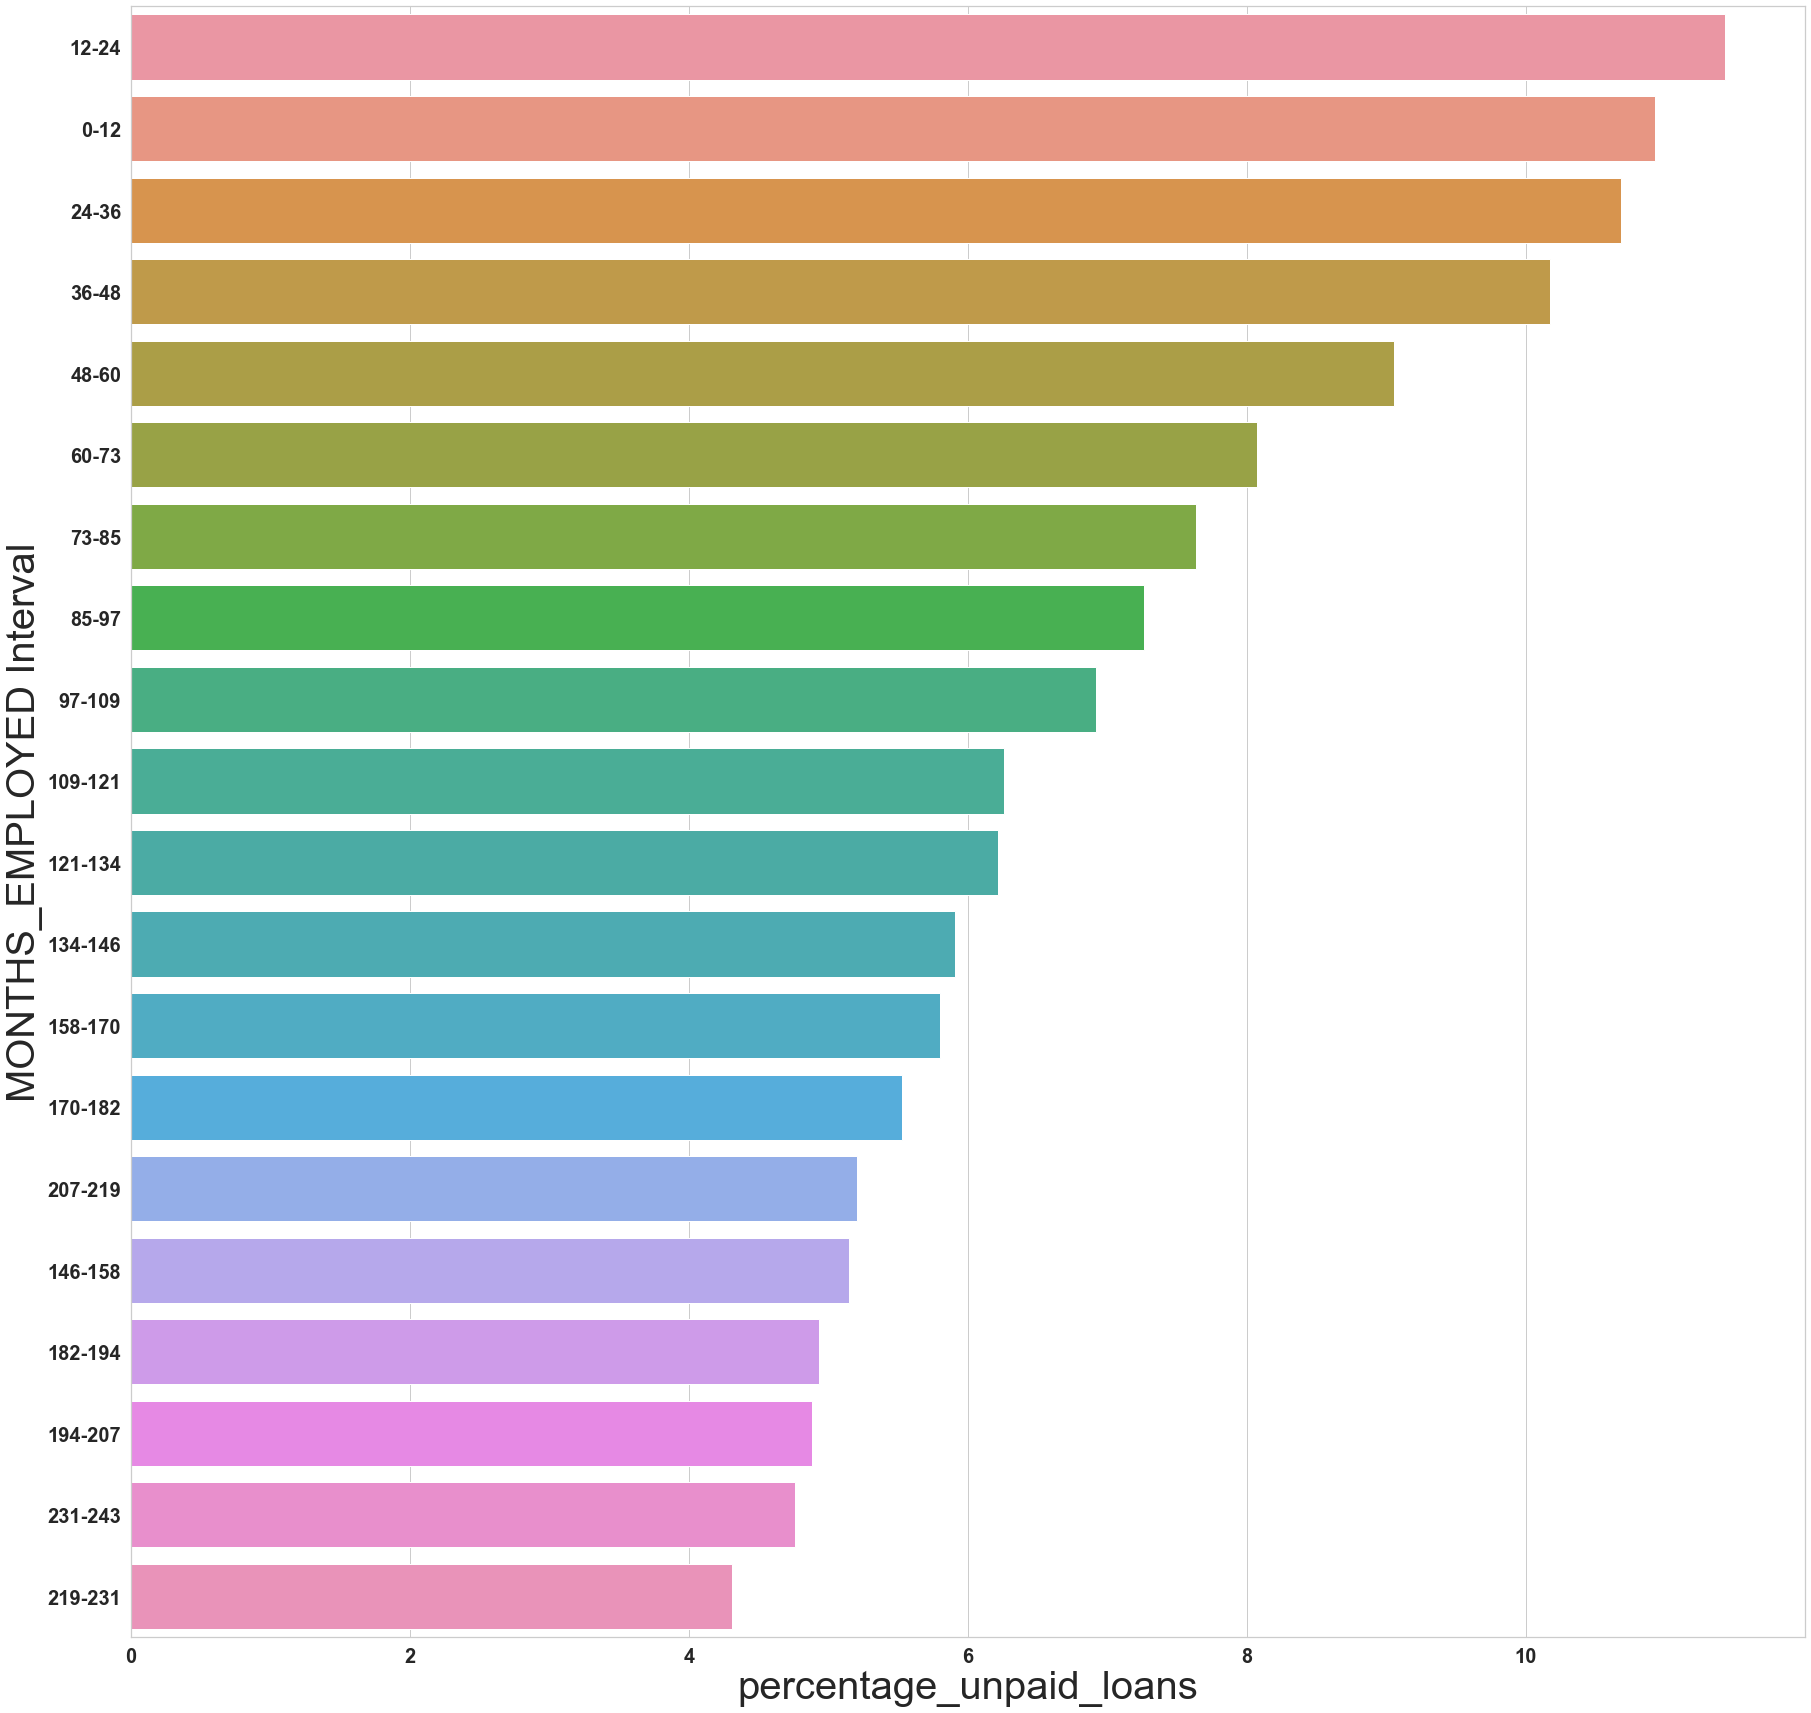

In [17]:
plotPercentageUnpaidPerBin(totalCountAndUnpaidCountPerIntervalMonthsEmployed, "MONTHS_EMPLOYED Interval")

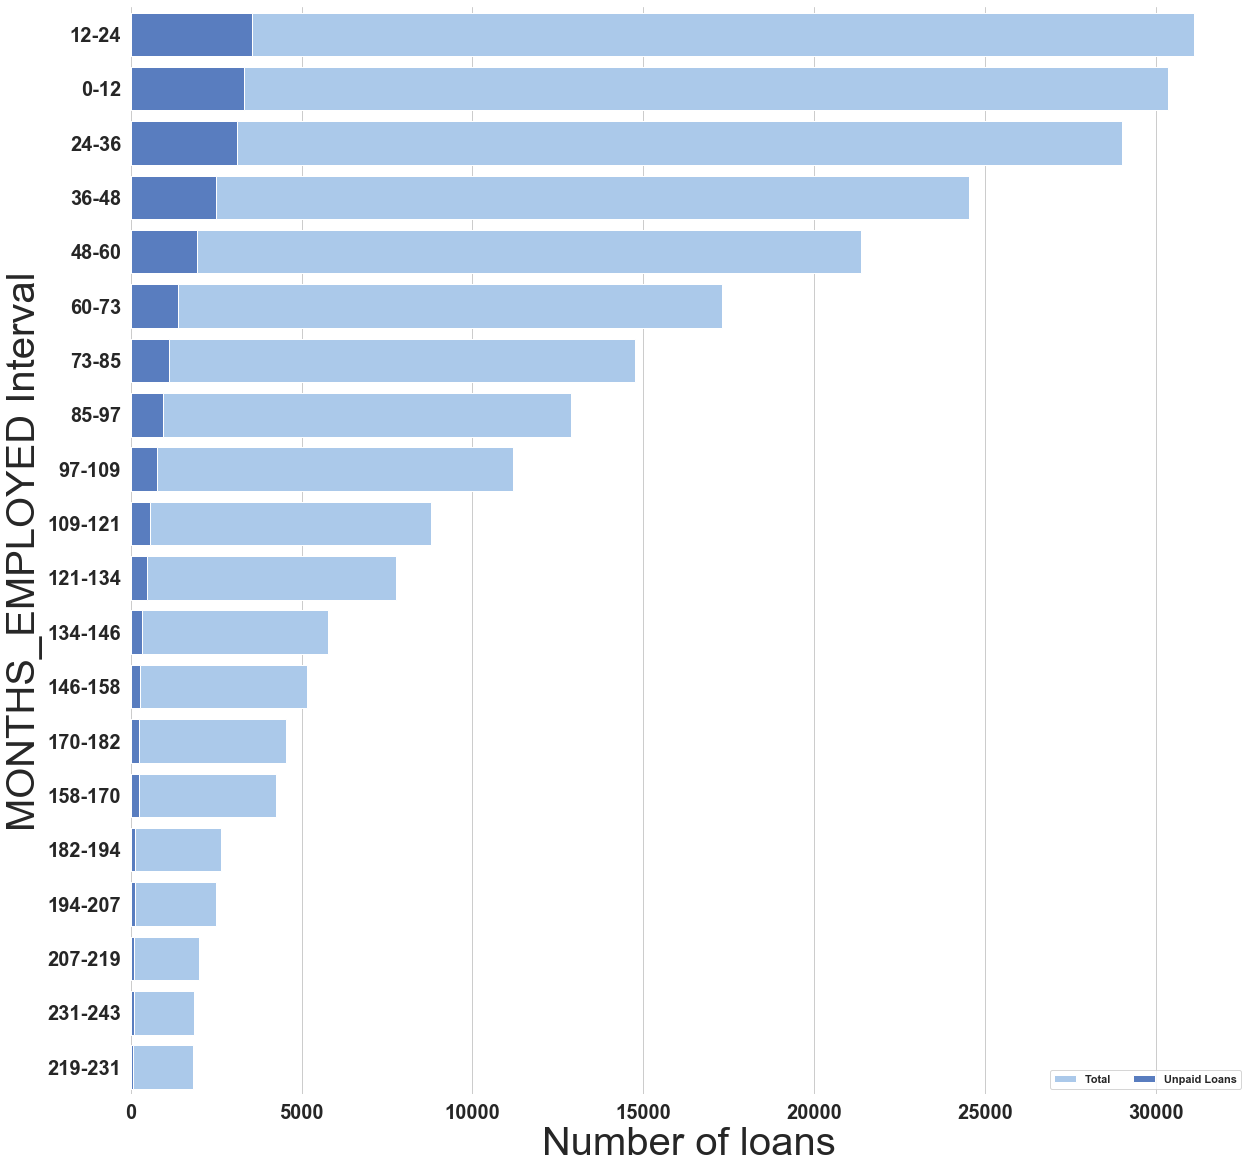

In [14]:
plotTotalAndUnpaidLoansPerBin(totalCountAndUnpaidCountPerIntervalMonthsEmployed, "MONTHS_EMPLOYED Interval")